In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✅ Libraries loaded successfully")
print("\n📚 This tutorial covers:")
print("  1. Regime Switching Systems")
print("  2. Jump Diffusion Processes")
print("  3. Combined MRSJD Models")
print("  4. Numerical Methods (Finite Differences, Upwind Schemes)")
print("  5. Practical Parameter Selection")

✅ Libraries loaded successfully

📚 This tutorial covers:
  1. Regime Switching Systems
  2. Jump Diffusion Processes
  3. Combined MRSJD Models
  4. Numerical Methods (Finite Differences, Upwind Schemes)
  5. Practical Parameter Selection


## 2. Mathematical Background <a id="math"></a>

### Stochastic Differential Equations (SDEs)

A general SDE has the form:

$$
dX_t = \mu(X_t)dt + \sigma(X_t)dW_t
$$

where:
- $\mu(X_t)$ = **drift** (deterministic trend)
- $\sigma(X_t)$ = **diffusion** (volatility)
- $dW_t$ = **Wiener process** increment: $dW_t \sim \mathcal{N}(0, dt)$

### Key Properties

**Itô's Lemma** (chain rule for SDEs):

For $Y_t = f(X_t)$:

$$
dY_t = f'(X_t)dX_t + \frac{1}{2}f''(X_t)\sigma^2(X_t)dt
$$

**Feynman-Kac Formula** (connects PDEs to expectations):

$$
V(x,t) = \mathbb{E}_x\left[ \int_t^T e^{-\rho(s-t)} L(X_s)ds + e^{-\rho(T-t)}\Phi(X_T) \right]
$$

satisfies the PDE:

$$
\frac{\partial V}{\partial t} + \mu(x)\frac{\partial V}{\partial x} + \frac{1}{2}\sigma^2(x)\frac{\partial^2 V}{\partial x^2} - \rho V + L(x) = 0
$$

### Example: Ornstein-Uhlenbeck Process

Mean-reverting process:

$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t
$$

- $\theta$ = speed of mean reversion
- $\mu$ = long-term mean
- $\sigma$ = volatility

**Half-life**: $t_{1/2} = \frac{\ln 2}{\theta}$

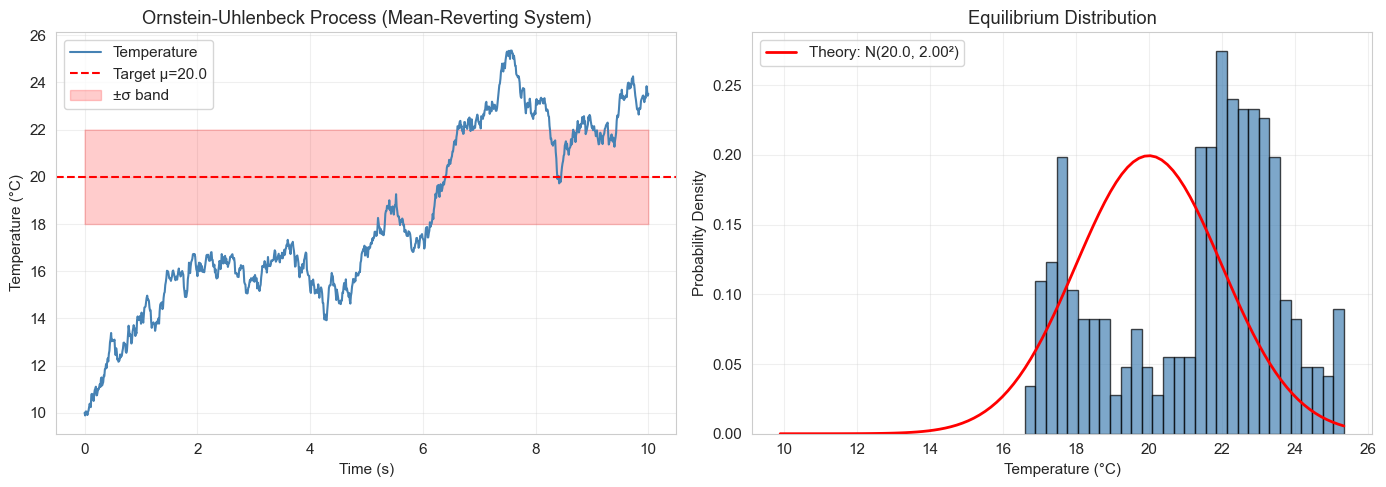


📊 OU Process Analysis:
  Half-life: 1.39 seconds
  Theoretical equilibrium std: 2.00
  Observed equilibrium std: 2.31


In [2]:
# Simulate Ornstein-Uhlenbeck process
def simulate_ou(theta, mu, sigma, x0, T, dt):
    """
    Simulate Ornstein-Uhlenbeck process using Euler-Maruyama method
    
    dX_t = θ(μ - X_t)dt + σ dW_t
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    X[0] = x0
    
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW
    
    return t, X

# Example: Temperature control
theta = 0.5  # Mean reversion speed
mu = 20.0    # Target temperature (°C)
sigma = 2.0  # Noise level
x0 = 10.0    # Initial temperature
T = 10.0     # Time horizon (seconds)
dt = 0.01    # Time step

t, X = simulate_ou(theta, mu, sigma, x0, T, dt)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Trajectory
ax1.plot(t, X, linewidth=1.5, color='steelblue', label='Temperature')
ax1.axhline(y=mu, color='red', linestyle='--', label=f'Target μ={mu}')
ax1.fill_between(t, mu-sigma, mu+sigma, alpha=0.2, color='red', label='±σ band')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Ornstein-Uhlenbeck Process (Mean-Reverting System)')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution at equilibrium
equilibrium_samples = X[len(X)//2:]  # Second half (near equilibrium)
ax2.hist(equilibrium_samples, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')

# Theoretical distribution: N(μ, σ²/(2θ))
x_range = np.linspace(X.min(), X.max(), 100)
theoretical_std = sigma / np.sqrt(2 * theta)
from scipy.stats import norm
ax2.plot(x_range, norm.pdf(x_range, mu, theoretical_std), 
        'r-', linewidth=2, label=f'Theory: N({mu:.1f}, {theoretical_std:.2f}²)')

ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Probability Density')
ax2.set_title('Equilibrium Distribution')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 OU Process Analysis:")
print(f"  Half-life: {np.log(2)/theta:.2f} seconds")
print(f"  Theoretical equilibrium std: {theoretical_std:.2f}")
print(f"  Observed equilibrium std: {equilibrium_samples.std():.2f}")

## 3. Regime Switching Systems <a id="regime"></a>

### Motivation

Many real systems exhibit **multiple operating modes** or **regimes**:
- Weather: sunny ↔ rainy ↔ stormy
- Manufacturing: normal ↔ maintenance ↔ failure
- Traffic: free-flow ↔ congested ↔ gridlock
- Economic activity: expansion ↔ recession

### Continuous-Time Markov Chain

The regime $i_t \in \{1, 2, ..., N\}$ follows a Markov chain with **transition rate matrix** $Q$:

$$
\mathbb{P}(i_{t+dt} = j | i_t = i) = 
\begin{cases}
q_{ij} dt & \text{if } i \neq j \\
1 + q_{ii} dt & \text{if } i = j
\end{cases}
$$

where $q_{ii} = -\sum_{j \neq i} q_{ij}$ (rows sum to zero).

### Coupled HJB System

The value function $V^i(x)$ in regime $i$ satisfies:

$$
\rho V^i(x) = \sup_u \left[ \mu^i(x,u) (V^i)'(x) + \frac{1}{2}(\sigma^i)^2(x,u) (V^i)''(x) + L^i(x,u) + \sum_{j \neq i} q_{ij}[V^j(x) - V^i(x)] \right]
$$

Key insight: The term $\sum_{j \neq i} q_{ij}[V^j(x) - V^i(x)]$ represents the **expected change in value due to regime switching**.

### Stationary Distribution

The long-run probability of being in each regime solves:

$$
Q^T \pi = 0, \quad \sum_i \pi_i = 1
$$

### Parameter Selection Tips

| Parameter | Typical Range | Effect | How to Choose |
|-----------|--------------|--------|---------------|
| $q_{ij}$ | 0.1 - 10.0 | Regime persistence | Higher = faster switching. Set $q_{ij} = 1/\text{expected duration}$ |
| $\mu^i$ | Problem-specific | Drift in regime $i$ | Estimate from data or physics |
| $\sigma^i$ | $> 0$ | Volatility in regime $i$ | Measure from observations or experiments |

**Example**: If regime 1 typically lasts 5 time units, set $q_{12} \approx 0.2$.

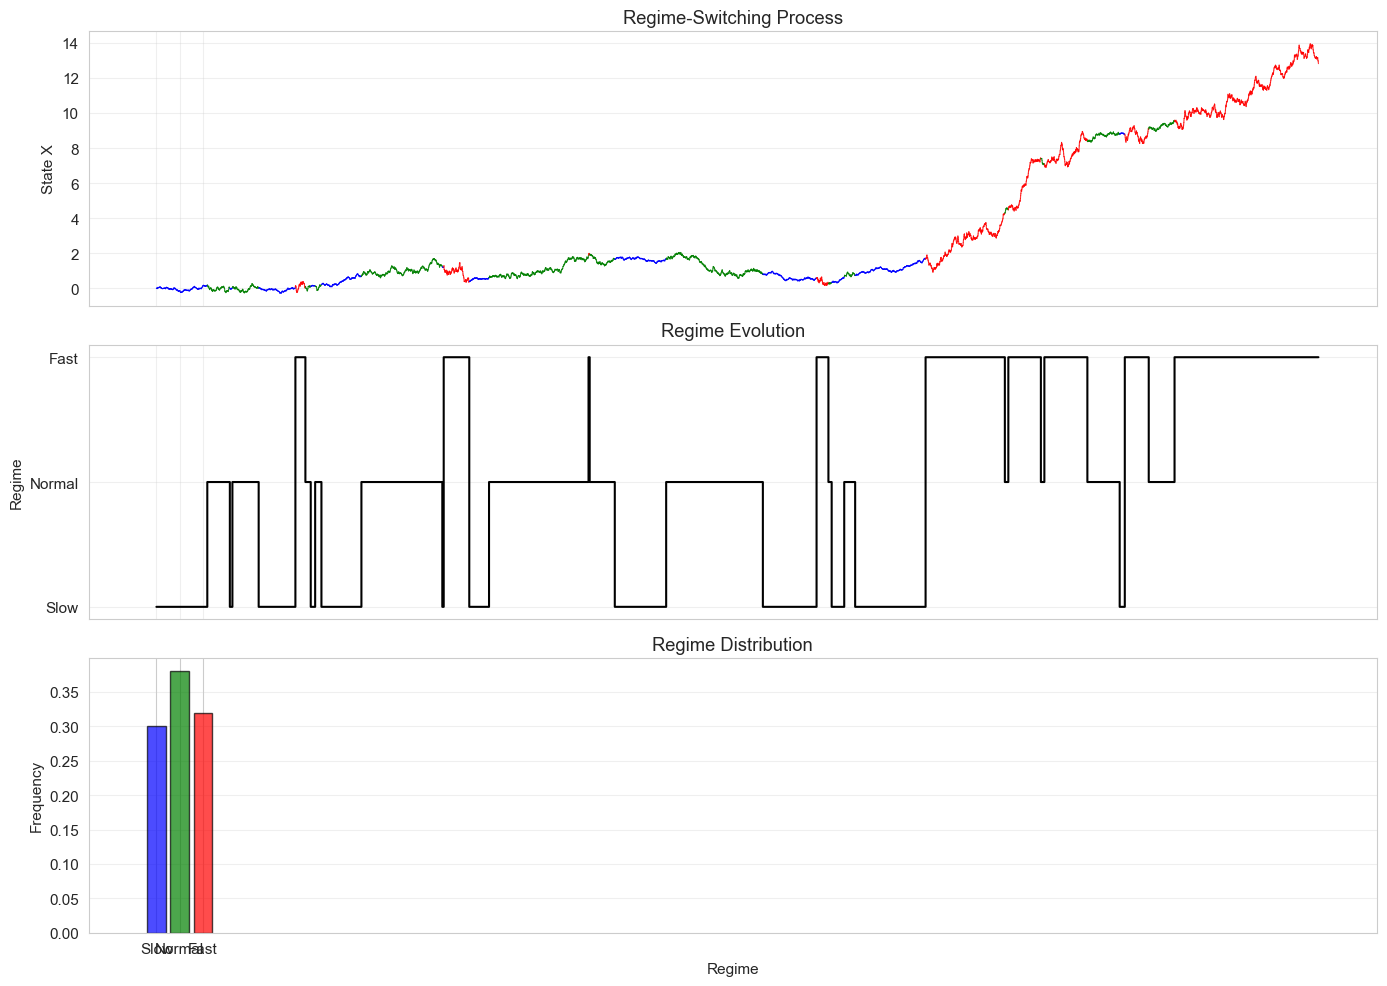


📊 Regime Switching Analysis:
  Observed frequencies: [0.3002 0.3802 0.3196]
  Theoretical stationary: [0.41573034 0.3258427  0.25842697]


In [3]:
# Simulate regime-switching process
def simulate_regime_switching(Q, regime_params, x0, T, dt):
    """
    Simulate regime-switching stochastic process
    
    Args:
        Q: Transition rate matrix (N x N)
        regime_params: List of (mu, sigma) for each regime
        x0: Initial state
        T: Time horizon
        dt: Time step
    """
    n_steps = int(T / dt)
    n_regimes = Q.shape[0]
    
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    regimes = np.zeros(n_steps, dtype=int)
    
    X[0] = x0
    regimes[0] = 0  # Start in regime 0
    
    for i in range(1, n_steps):
        current_regime = regimes[i-1]
        
        # Check for regime transition
        for j in range(n_regimes):
            if j != current_regime:
                if np.random.rand() < Q[current_regime, j] * dt:
                    current_regime = j
                    break
        
        regimes[i] = current_regime
        
        # Evolve state according to current regime
        mu, sigma = regime_params[current_regime]
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + mu * dt + sigma * dW
    
    return t, X, regimes

# Example: 3-regime system (Slow/Normal/Fast)
Q = np.array([
    [-0.5,  0.3,  0.2],  # Slow regime
    [ 0.4, -0.7,  0.3],  # Normal regime
    [ 0.3,  0.4, -0.7]   # Fast regime
])

regime_params = [
    (0.1, 0.2),  # Slow: low drift, low vol
    (0.3, 0.4),  # Normal: medium drift, medium vol
    (0.5, 0.8)   # Fast: high drift, high vol
]

t, X, regimes = simulate_regime_switching(Q, regime_params, x0=0.0, T=50.0, dt=0.01)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# State trajectory
colors = ['blue', 'green', 'red']
for i in range(len(t)-1):
    ax1.plot(t[i:i+2], X[i:i+2], color=colors[regimes[i]], alpha=0.8, linewidth=0.8)

ax1.set_ylabel('State X')
ax1.set_title('Regime-Switching Process')
ax1.grid(alpha=0.3)

# Regime evolution
ax2.step(t, regimes, where='post', linewidth=1.5, color='black')
ax2.set_ylabel('Regime')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Slow', 'Normal', 'Fast'])
ax2.set_title('Regime Evolution')
ax2.grid(alpha=0.3)

# Regime distribution
regime_counts = np.bincount(regimes, minlength=3) / len(regimes)
ax3.bar([0, 1, 2], regime_counts, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Regime')
ax3.set_ylabel('Frequency')
ax3.set_xticks([0, 1, 2])
ax3.set_xticklabels(['Slow', 'Normal', 'Fast'])
ax3.set_title('Regime Distribution')
ax3.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Compute stationary distribution
from scipy.linalg import null_space
pi_stationary = null_space(Q.T)
pi_stationary = pi_stationary / pi_stationary.sum()

print("\n📊 Regime Switching Analysis:")
print(f"  Observed frequencies: {regime_counts}")
print(f"  Theoretical stationary: {pi_stationary.flatten()}")

## 4. Jump Diffusion Processes <a id="jumps"></a>

### Motivation

Continuous diffusion models fail to capture **sudden, discrete events**:
- Market crashes/rallies
- Equipment failures
- Policy changes
- Natural disasters
- Phase transitions

### Lévy Processes and Compound Poisson

A jump diffusion process combines:
1. **Continuous diffusion**: $\sigma dW_t$
2. **Discrete jumps**: $dJ_t = \sum_{i=1}^{N_t} Y_i$

$$
dX_t = \mu dt + \sigma dW_t + dJ_t
$$

where:
- $N_t \sim \text{Poisson}(\lambda t)$ = number of jumps by time $t$
- $Y_i \sim F$ = jump size distribution
- $\lambda$ = **jump intensity** (expected jumps per unit time)

### HJB with Jump Integral

$$
\rho V(x) = \sup_u \left[ \mu(x,u) V'(x) + \frac{1}{2}\sigma^2(x,u) V''(x) + L(x,u) + \lambda \int [V(x+y) - V(x)] F(dy) \right]
$$

The integral term $\lambda \mathbb{E}[V(x+Y) - V(x)]$ represents the **expected value change from jumps**.

### Jump Size Distributions

| Distribution | Density | Use Case |
|--------------|---------|----------|
| Normal | $\mathcal{N}(\mu_j, \sigma_j^2)$ | Symmetric jumps (up/down equally likely) |
| Exponential | $\lambda e^{-\lambda y}$ | One-sided jumps (failures, crashes) |
| Laplace | $\frac{1}{2b}e^{-|y-\mu|/b}$ | Heavy-tailed jumps |
| Uniform | $U(a, b)$ | Bounded jumps |

### Parameter Selection

| Parameter | Typical Range | Effect | How to Choose |
|-----------|--------------|--------|---------------|
| $\lambda$ | 0.01 - 5.0 | Jump frequency | Count events per unit time from data |
| $\mu_j$ | Problem-specific | Average jump size | Measure typical event magnitude |
| $\sigma_j$ | $> 0$ | Jump size variability | Standard deviation of observed jumps |

**Rule of thumb**: If you expect ~1 jump per 10 time units, set $\lambda = 0.1$.

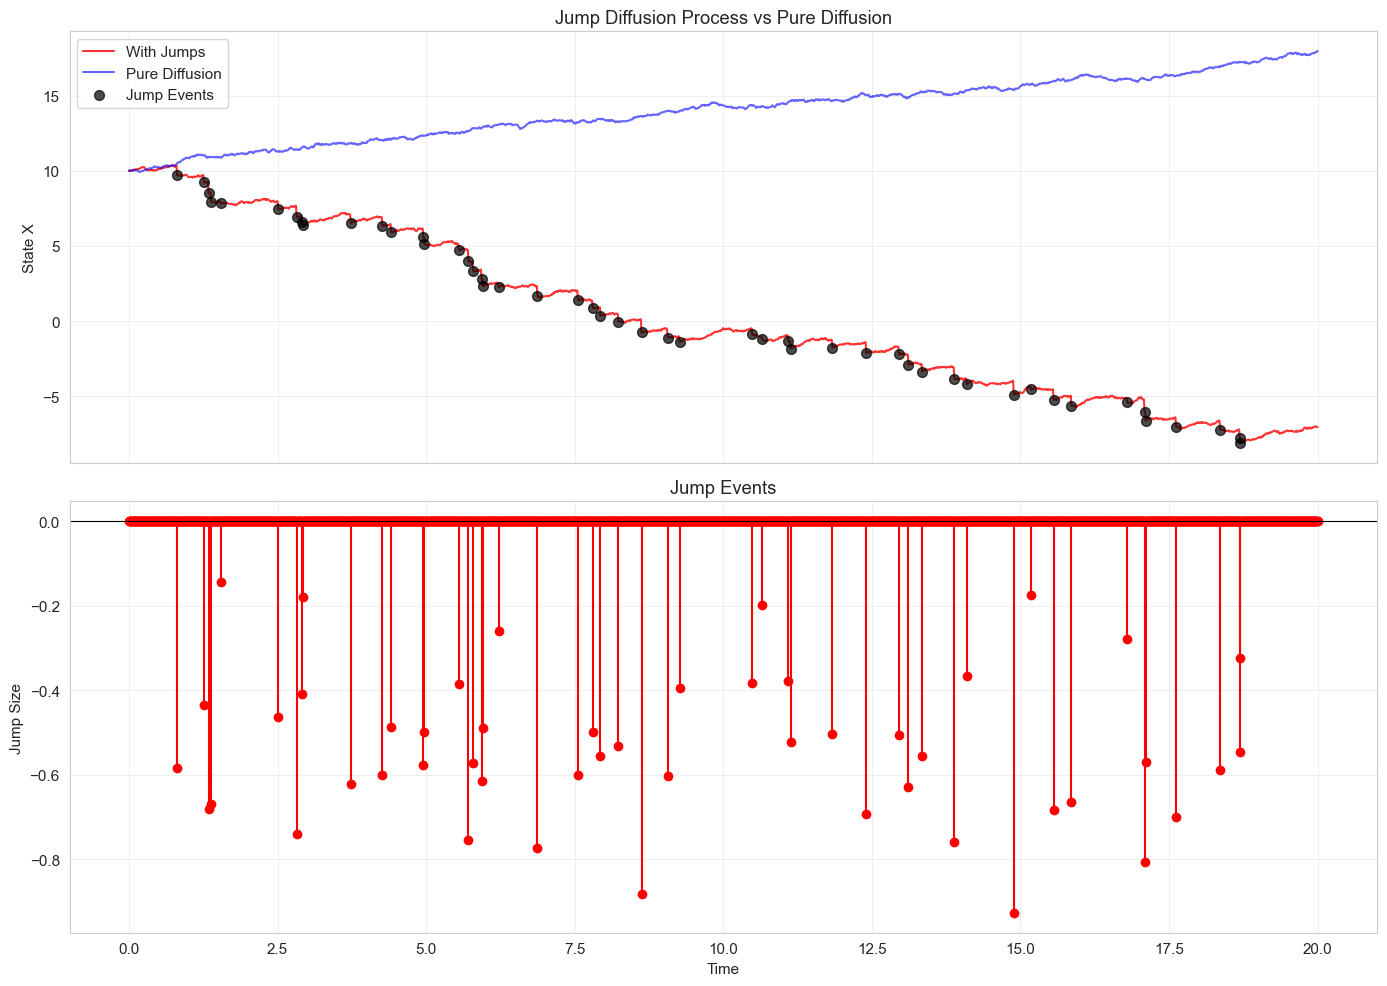


📊 Jump Diffusion Analysis:
  Expected jumps: 40.0
  Observed jumps: 50
  Average jump size: -0.536 (theoretical: -0.5)
  Std of jumps: 0.178 (theoretical: 0.2)

  Impact: Final value with jumps = -7.04 vs 17.97 without jumps


In [4]:
# Simulate jump diffusion process
def simulate_jump_diffusion(mu, sigma, lambda_jump, jump_mean, jump_std, x0, T, dt):
    """
    Simulate Merton jump diffusion model
    
    dX_t = μ dt + σ dW_t + dJ_t
    
    where J_t is compound Poisson with Normal jumps
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    jumps = np.zeros(n_steps)
    
    X[0] = x0
    
    for i in range(1, n_steps):
        # Diffusion component
        dW = np.random.normal(0, np.sqrt(dt))
        dX = mu * dt + sigma * dW
        
        # Jump component
        n_jumps = np.random.poisson(lambda_jump * dt)
        if n_jumps > 0:
            jump_sizes = np.random.normal(jump_mean, jump_std, n_jumps)
            total_jump = jump_sizes.sum()
            dX += total_jump
            jumps[i] = total_jump
        
        X[i] = X[i-1] + dX
    
    return t, X, jumps

# Example: System with occasional failures/shocks
mu = 0.5        # Baseline drift
sigma = 0.3     # Continuous volatility
lambda_jump = 2.0  # 2 jumps per time unit (on average)
jump_mean = -0.5   # Negative jumps (failures)
jump_std = 0.2     # Jump size variability
x0 = 10.0       # Initial state
T = 20.0        # Time horizon
dt = 0.01

t, X, jumps = simulate_jump_diffusion(mu, sigma, lambda_jump, jump_mean, jump_std, x0, T, dt)

# Also simulate without jumps for comparison
t_nodiff, X_nodiff, _ = simulate_jump_diffusion(mu, sigma, 0.0, 0.0, 0.0, x0, T, dt)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Trajectories comparison
ax1.plot(t, X, linewidth=1.5, color='red', label='With Jumps', alpha=0.8)
ax1.plot(t_nodiff, X_nodiff, linewidth=1.5, color='blue', label='Pure Diffusion', alpha=0.6)

# Mark jump times
jump_times = t[jumps != 0]
jump_values = X[jumps != 0]
ax1.scatter(jump_times, jump_values, color='black', s=50, zorder=5, label='Jump Events', alpha=0.7)

ax1.set_ylabel('State X')
ax1.set_title('Jump Diffusion Process vs Pure Diffusion')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Jump sizes over time
ax2.stem(t, jumps, linefmt='red', markerfmt='ro', basefmt=' ', label='Jump Sizes')
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Jump Size')
ax2.set_title('Jump Events')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
n_observed_jumps = np.sum(jumps != 0)
expected_jumps = lambda_jump * T
avg_jump_size = jumps[jumps != 0].mean() if n_observed_jumps > 0 else 0

print("\n📊 Jump Diffusion Analysis:")
print(f"  Expected jumps: {expected_jumps:.1f}")
print(f"  Observed jumps: {n_observed_jumps}")
print(f"  Average jump size: {avg_jump_size:.3f} (theoretical: {jump_mean})")
print(f"  Std of jumps: {jumps[jumps != 0].std() if n_observed_jumps > 0 else 0:.3f} (theoretical: {jump_std})")
print(f"\n  Impact: Final value with jumps = {X[-1]:.2f} vs {X_nodiff[-1]:.2f} without jumps")

## 5. Combined MRSJD Models <a id="mrsjd"></a>

### Why Combine Regime Switching and Jumps?

Real systems often exhibit **both**:
1. **State-dependent behavior** (regimes)
2. **Sudden shocks** (jumps)

Examples:
- **Manufacturing**: Normal/maintenance regimes + equipment failures (jumps)
- **Power grid**: Low/high demand regimes + blackout events (jumps)
- **Epidemic**: Endemic/outbreak regimes + super-spreader events (jumps)

### Full MRSJD Dynamics

$$
dX_t = \mu^{i_t}(X_t)dt + \sigma^{i_t}(X_t)dW_t + dJ_t^{i_t}
$$

where:
- Drift $\mu^i$ and volatility $\sigma^i$ depend on current regime $i_t$
- Jump intensity $\lambda^i$ and distribution $F^i$ also regime-dependent
- Regime switches according to $Q$

### Coupled HJB with Both Effects

$$
\boxed{
\rho V^i(x) = \sup_u \left[ \mu^i V^i_x + \frac{(\sigma^i)^2}{2} V^i_{xx} + L^i(x,u) + \lambda^i \int [V^i(x+y) - V^i(x)] F^i(dy) + \sum_{j \neq i} q_{ij}[V^j(x) - V^i(x)] \right]
}
$$

This is the **most general** formulation combining:
1. ✅ Diffusion: $(\sigma^i)^2 V^i_{xx}$
2. ✅ Jumps: $\lambda^i \int [V^i(x+y) - V^i(x)] F^i(dy)$
3. ✅ Regime Switching: $\sum_{j \neq i} q_{ij}[V^j(x) - V^i(x)]$
4. ✅ Optimal Control: $\sup_u$

### Numerical Solution: Finite Differences with Upwind Schemes

**Grid discretization**: $x_k = x_{\min} + k \Delta x$, $k = 0, ..., N$

**Value function approximation**: $V^i(x_k) \approx V^i_k$

**Derivatives**:
- Forward: $V_x \approx (V_{k+1} - V_k) / \Delta x$
- Backward: $V_x \approx (V_k - V_{k-1}) / \Delta x$
- Central: $V_{xx} \approx (V_{k+1} - 2V_k + V_{k-1}) / (\Delta x)^2$

**Upwind scheme** (for stability when $\mu \neq 0$):
$$
V_x \approx 
\begin{cases}
(V_{k+1} - V_k) / \Delta x & \text{if } \mu > 0 \text{ (forward)} \\
(V_k - V_{k-1}) / \Delta x & \text{if } \mu < 0 \text{ (backward)}
\end{cases}
$$

**Why upwind?** Prevents numerical oscillations when advection dominates diffusion.

### Algorithm: Value Iteration

```
1. Initialize V^i_k = 0 for all regimes i and grid points k
2. Repeat until convergence:
   For each regime i:
     For each grid point k:
       a. Compute derivatives V_x, V_xx
       b. Compute jump integral ∫[V(x+y) - V(x)]F(dy)
       c. Compute regime switching term Σ q_ij[V^j - V^i]
       d. Optimize over control: u* = argmax_u RHS(u)
       e. Update: V^i_k ← RHS(u*) / ρ
3. Convergence check: ||V_new - V_old|| < tol
```

### Computational Complexity

- **Per iteration**: $O(N \cdot M \cdot K)$
  - $N$ = number of regimes
  - $M$ = grid points
  - $K$ = control discretization
- **Iterations**: Typically 100-1000
- **Total**: $O(10^5 - 10^7)$ operations

**Speedup techniques**:
- Parallel computation across regimes (Rayon)
- Adaptive grid refinement
- Policy iteration instead of value iteration
- Sparse matrix operations

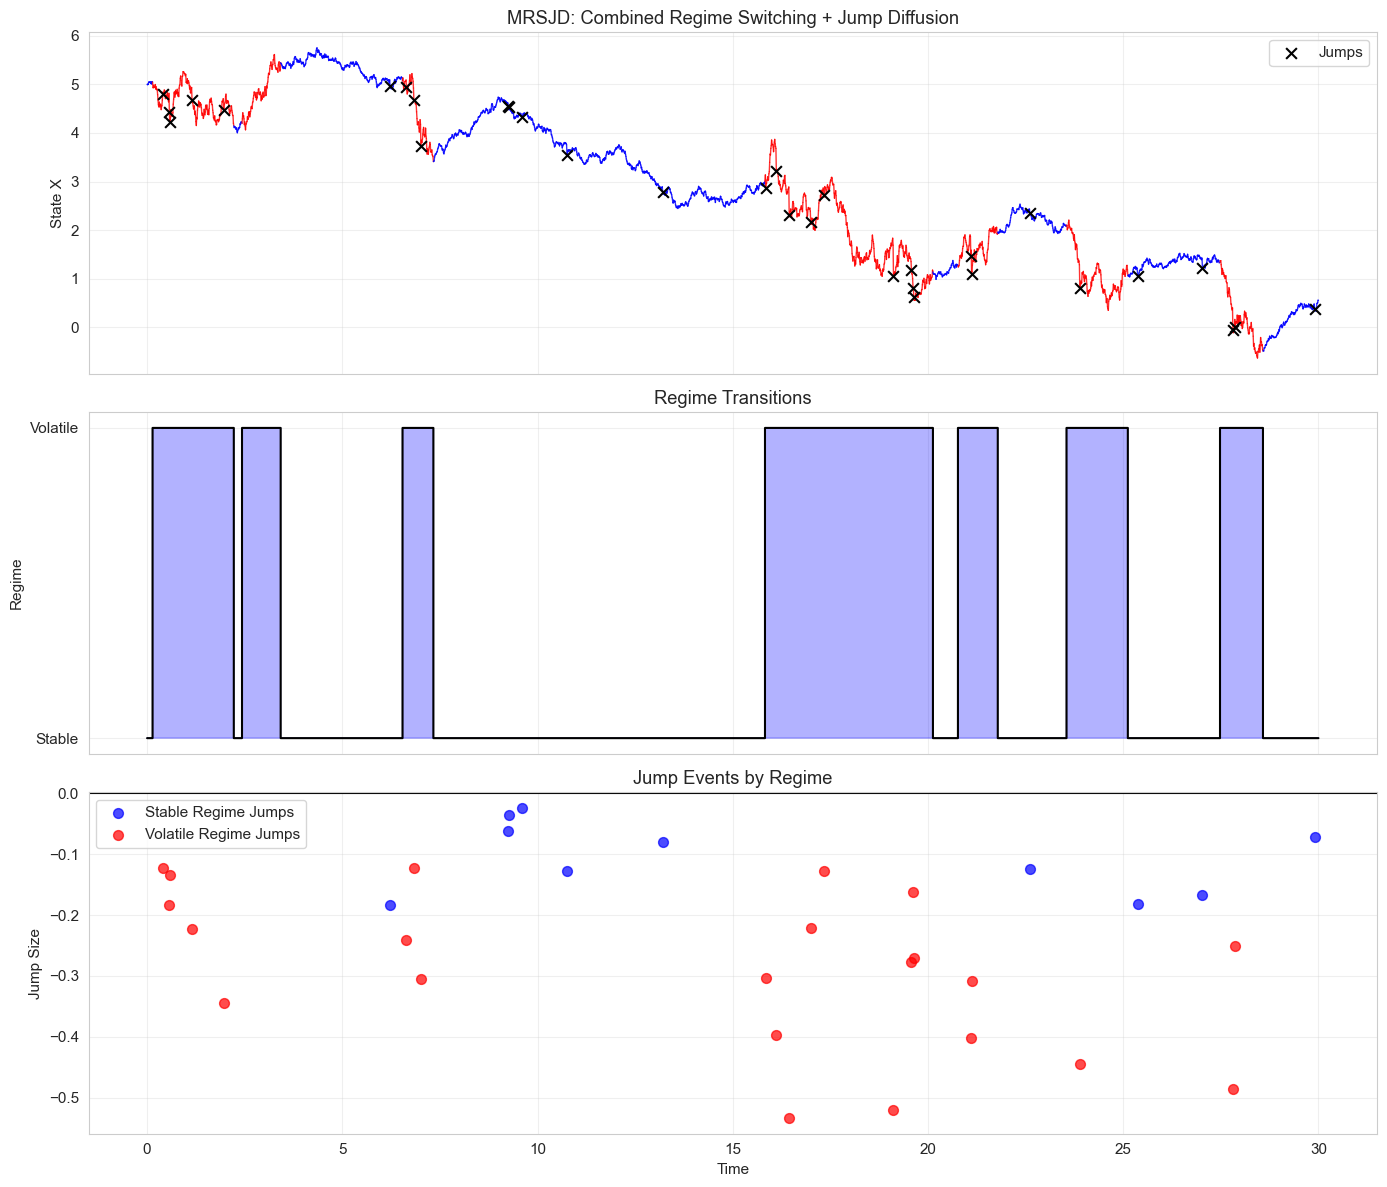


📊 MRSJD Analysis:
  Total jumps: 32
  Time in Stable regime: 18.2 (90.8%)
  Time in Volatile regime: 11.8 (59.2%)
  Average jump size (Stable): -0.106
  Average jump size (Volatile): -0.290


In [5]:
# Simplified MRSJD simulation (for illustration)
def simulate_mrsjd(Q, regime_params_list, x0, T, dt):
    """
    Simulate Markov Regime Switching Jump Diffusion
    
    Each regime has: (mu, sigma, lambda_jump, jump_mean, jump_std)
    """
    n_steps = int(T / dt)
    n_regimes = Q.shape[0]
    
    t = np.linspace(0, T, n_steps)
    X = np.zeros(n_steps)
    regimes = np.zeros(n_steps, dtype=int)
    jump_events = []
    
    X[0] = x0
    regimes[0] = 0
    
    for i in range(1, n_steps):
        current_regime = regimes[i-1]
        mu, sigma, lam, jmu, jsig = regime_params_list[current_regime]
        
        # Check regime transition
        for j in range(n_regimes):
            if j != current_regime and np.random.rand() < Q[current_regime, j] * dt:
                current_regime = j
                break
        
        regimes[i] = current_regime
        
        # Diffusion
        dW = np.random.normal(0, np.sqrt(dt))
        dX = mu * dt + sigma * dW
        
        # Jumps (regime-dependent)
        n_jumps = np.random.poisson(lam * dt)
        if n_jumps > 0:
            jump_size = np.sum(np.random.normal(jmu, jsig, n_jumps))
            dX += jump_size
            jump_events.append((t[i], jump_size, current_regime))
        
        X[i] = X[i-1] + dX
    
    return t, X, regimes, jump_events

# Example: 2-regime system with regime-dependent jumps
Q = np.array([
    [-0.3, 0.3],
    [0.5, -0.5]
])

# Regime 0: Stable (low vol, rare small jumps)
# Regime 1: Volatile (high vol, frequent large jumps)
regime_params_list = [
    (0.2, 0.3, 0.5, -0.1, 0.05),  # Stable: mu, sigma, lambda, jump_mu, jump_sigma
    (0.1, 0.8, 2.0, -0.3, 0.15)   # Volatile
]

t, X, regimes, jump_events = simulate_mrsjd(Q, regime_params_list, x0=5.0, T=30.0, dt=0.01)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# State trajectory
regime_colors = ['blue', 'red']
for i in range(len(t)-1):
    axes[0].plot(t[i:i+2], X[i:i+2], color=regime_colors[regimes[i]], alpha=0.8, linewidth=1.0)

# Mark jumps
if jump_events:
    jump_t = [j[0] for j in jump_events]
    jump_idx = [np.argmin(np.abs(t - jt)) for jt in jump_t]
    axes[0].scatter([t[i] for i in jump_idx], [X[i] for i in jump_idx], 
                   color='black', s=60, zorder=5, marker='x', label='Jumps')

axes[0].set_ylabel('State X')
axes[0].set_title('MRSJD: Combined Regime Switching + Jump Diffusion')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Regime evolution
axes[1].step(t, regimes, where='post', linewidth=1.5, color='black')
axes[1].fill_between(t, regimes, alpha=0.3, step='post', 
                     color=['blue' if r==0 else 'red' for r in regimes])
axes[1].set_ylabel('Regime')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Stable', 'Volatile'])
axes[1].set_title('Regime Transitions')
axes[1].grid(alpha=0.3)

# Jump events by regime
if jump_events:
    regime_0_jumps = [j for j in jump_events if j[2] == 0]
    regime_1_jumps = [j for j in jump_events if j[2] == 1]
    
    if regime_0_jumps:
        axes[2].scatter([j[0] for j in regime_0_jumps], [j[1] for j in regime_0_jumps],
                       color='blue', s=50, alpha=0.7, label='Stable Regime Jumps')
    if regime_1_jumps:
        axes[2].scatter([j[0] for j in regime_1_jumps], [j[1] for j in regime_1_jumps],
                       color='red', s=50, alpha=0.7, label='Volatile Regime Jumps')

axes[2].axhline(y=0, color='black', linewidth=0.8)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Jump Size')
axes[2].set_title('Jump Events by Regime')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n📊 MRSJD Analysis:")
print(f"  Total jumps: {len(jump_events)}")
regime_times = [np.sum(regimes == i) * dt for i in range(2)]
print(f"  Time in Stable regime: {regime_times[0]:.1f} ({regime_times[0]/T*100:.1f}%)")
print(f"  Time in Volatile regime: {regime_times[1]:.1f} ({regime_times[1]/T*100:.1f}%)")
if jump_events:
    avg_jump_0 = np.mean([j[1] for j in jump_events if j[2] == 0]) if len([j for j in jump_events if j[2] == 0]) > 0 else 0
    avg_jump_1 = np.mean([j[1] for j in jump_events if j[2] == 1]) if len([j for j in jump_events if j[2] == 1]) > 0 else 0
    print(f"  Average jump size (Stable): {avg_jump_0:.3f}")
    print(f"  Average jump size (Volatile): {avg_jump_1:.3f}")

## 6. Practical Parameter Selection Guide <a id="params"></a>

### How to Choose Parameters for Your Problem

#### Step 1: Identify Regimes

Ask: Does the system have distinct "modes" or "states"?

**Examples**:
- Manufacturing: Normal / Degraded / Failed
- Weather: Clear / Cloudy / Storm
- Network: Low / Medium / High traffic

**Tip**: Start with 2-3 regimes. More regimes = more parameters to estimate.

#### Step 2: Estimate Regime Persistence

**Question**: How long does each regime typically last?

**Formula**: $q_{ij} = \frac{1}{\text{expected duration in regime } i}$

**Example**: If "Normal" regime lasts ~10 time units:
- Total exit rate from Normal: $q_{01} + q_{02} = 0.1$
- Split based on transition probabilities

#### Step 3: Characterize Within-Regime Dynamics

For each regime $i$:

| Parameter | Method | Example |
|-----------|--------|----------|
| $\mu^i$ | Sample mean of increments | $\bar{\Delta X} / \Delta t$ |
| $\sigma^i$ | Sample std of increments | $\text{std}(\Delta X) / \sqrt{\Delta t}$ |
| $\lambda^i$ | Count events per time | $N_{\text{jumps}} / T$ |
| Jump mean | Average jump size | $\bar{Y}$ |
| Jump std | Std of jump sizes | $\text{std}(Y)$ |

#### Step 4: Validate with Simulations

Before solving the HJB:
1. Simulate the process with chosen parameters
2. Check if trajectories "look right"
3. Compare summary statistics to data
4. Adjust and iterate

### Common Pitfalls and Solutions

| Problem | Symptom | Solution |
|---------|---------|----------|
| Too many regimes | Overfitting, unstable estimates | Use 2-3 regimes; combine similar ones |
| Wrong time scale | Unrealistic dynamics | Match $q_{ij}$ to actual durations |
| Numerical instability | Oscillations, divergence | Reduce grid spacing, use upwind scheme |
| Slow convergence | Many iterations needed | Better initial guess, increase tolerance |
| High dimensionality | Curse of dimensionality | Reduce state space, use approximations |

### Sensitivity Analysis

Always check how results change with parameters:
1. Vary each parameter by ±20%
2. Observe impact on optimal policy and value function
3. Identify which parameters matter most
4. Focus calibration efforts on sensitive parameters

### When to Use vs. Not Use

✅ **Good fit for HJB optimal control**:
- Continuous state space (position, temperature, concentration)
- Known or learnable dynamics
- Quantifiable objectives
- Medium-dimensional problems (1-3 state variables)
- Offline planning acceptable

❌ **Not recommended**:
- Purely discrete decisions (use dynamic programming)
- Unknown dynamics (use reinforcement learning)
- High-dimensional state (>5 variables)
- Real-time requirements (<1ms response)
- Purely deterministic problems (use calculus of variations)

### Alternative Approaches

| Method | When to Use | Pros | Cons |
|--------|-------------|------|------|
| **LQR/LQG** | Linear dynamics, quadratic cost | Fast, analytical solution | Limited to LQ problems |
| **MPC** | Need real-time receding horizon | Handles constraints well | Computational cost |
| **RL (DQN, PPO)** | Unknown dynamics | Model-free, flexible | Sample inefficient |
| **PID Control** | Simple SISO systems | Easy to tune | No optimality guarantee |
| **Bang-Bang** | Hard constraints | Simple implementation | Non-smooth control |

### Further Reading

1. **Books**:
   - Fleming & Rishel: "Deterministic and Stochastic Optimal Control"
   - Øksendal & Sulem: "Applied Stochastic Control of Jump Diffusions"
   - Bertsekas: "Dynamic Programming and Optimal Control"

2. **Papers**:
   - Guo & Hernandez-Lerma: "Continuous-Time Markov Decision Processes"
   - Pham: "Continuous-time Stochastic Control and Optimization with Financial Applications"

3. **Software**:
   - This library (optimizr): Generic optimal control solvers
   - PROPT: MATLAB optimal control toolbox
   - CasADi: Nonlinear optimization and optimal control

## Summary and Next Steps

### What We Covered

1. ✅ **Optimal Control Theory**: HJB equations, value functions
2. ✅ **Regime Switching**: Markov chains, coupled HJB systems
3. ✅ **Jump Diffusion**: Lévy processes, compound Poisson
4. ✅ **MRSJD Models**: Combined framework for complex systems
5. ✅ **Numerical Methods**: Finite differences, upwind schemes, value iteration
6. ✅ **Parameter Selection**: Practical guidance and sensitivity analysis

### Key Takeaways

- Optimal control finds the **best** policy, not just a good one
- HJB equations require **solving PDEs** (computational cost)
- Regime switching captures **state-dependent behavior**
- Jumps model **sudden events** and tail risk
- Start simple (2 regimes, pure diffusion) then add complexity

### Exercises for Practice

1. **Temperature Control**: Design an optimal heating/cooling policy to maintain room temperature near 20°C while minimizing energy cost

2. **Inventory Management**: Optimize reorder policy for warehouse with regime-switching demand (normal/holiday)

3. **Robot Navigation**: Find optimal path for robot avoiding obstacles with uncertain dynamics and occasional sensor failures (jumps)

### Next Tutorial

- **Hidden Markov Models (HMM)**: When regime is not directly observable
- **MCMC Sampling**: Bayesian inference for parameter estimation
- **Sparse Optimization**: High-dimensional problems with sparsity

---

**Questions?** Open an issue on the repository or consult the API documentation.

**Happy Optimizing! 🚀**